<a href="https://colab.research.google.com/github/gabryelsguedes/Taxi-NY/blob/main/Predicao_taxi_ny.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Previsão de tarifa de táxi de Nova Iorque
A base de dados foi extraída desta competição do Kaggle: https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/overview.

In this playground competition, hosted in partnership with Google Cloud and Coursera, you are tasked with predicting the fare amount (inclusive of tolls) for a taxi ride in New York City given the pickup and dropoff locations. While you can get a basic estimate based on just the distance between the two points, this will result in an RMSE of $5-$8, depending on the model used (see the starter code for an example of this approach in Kernels). Your challenge is to do better than this using Machine Learning techniques!

To learn how to handle large datasets with ease and solve this problem using TensorFlow, consider taking the Machine Learning with TensorFlow on Google Cloud Platform specialization on Coursera -- the taxi fare problem is one of several real-world problems that are used as case studies in the series of courses. To make this easier, head to Coursera.org/NEXTextended to claim this specialization for free for the first month!

In [ ]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import random 
import zipfile
from datetime import datetime

###Extração de uma amostra da base de dados

Extração de uma parte dos dados para diminuir o tempo de processamento dos modelos.

In [ ]:
dataset_path = '/content/drive/MyDrive/Colab Notebooks/Dados - Taxi NY/train.csv.zip'
zip_object = zipfile.ZipFile(file=dataset_path, mode='r')
zip_object.extractall('./')
zip_object.close()

number_rows = sum(1 for line in open('train.csv'))
number_rows

sample_size = 50000
#sempre ter a mesma divisao da base de dados
random.seed(24) 
#linhas que serão excluidas da base de dados, range a partir da linha 1 para deixar o nome das colunas
skip_rows = sorted(random.sample(range(1,number_rows+1),number_rows-sample_size)) 
#skiprows linhas que serão exluidas
train = pd.read_csv('train.csv', skiprows=skip_rows)  
#Gerando uma amostra do arquivo de menor tamanho para treinar e baixar
train.to_csv('train_sample '+ str(sample_size) + '.csv', index=False)  

In [ ]:
dataset = pd.read_csv('/content/train_sample 50000.csv',
                    parse_dates=['key','pickup_datetime'],
                    dtype = {'fare_amount': np.float32,'pickup_latitude':np.float32,
                             'pickup_longitude':np.float32,'dropoff_latitude':np.float32,
                             'dropoff_longitude':np.float32,'passenger_count':np.int32})

In [ ]:
dataset.dtypes

key                       datetime64[ns]
fare_amount                      float32
pickup_datetime      datetime64[ns, UTC]
pickup_longitude                 float32
pickup_latitude                  float32
dropoff_longitude                float32
dropoff_latitude                 float32
passenger_count                    int32
dtype: object

In [ ]:
dataset.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2011-06-21 16:15:00.000000730,7.3,2011-06-21 16:15:00+00:00,-73.991875,40.754436,-73.977226,40.774323,3
1,2012-04-14 14:45:00.000000310,5.7,2012-04-14 14:45:00+00:00,-73.984322,40.768509,-73.988472,40.755569,1
2,2011-10-26 16:56:14.000000300,13.3,2011-10-26 16:56:14+00:00,-74.001305,40.724426,-73.971802,40.761963,1
3,2012-03-08 22:58:00.000000134,16.5,2012-03-08 22:58:00+00:00,-74.008240,40.720638,-73.951424,40.730354,2
4,2012-09-06 21:56:13.000000100,21.0,2012-09-06 21:56:13+00:00,-74.005928,40.709415,-73.996780,40.736568,2


In [ ]:
dataset.isna().sum()

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

###Analise das colunas key e pickup datetime

Analisar se será necessário usar as duas colunas ou se ambas são iguais.

In [ ]:
key = dataset['key']
key = pd.to_datetime(key.dt.strftime('%Y-%m-%d %H:%M:%S'))

pdt = dataset['pickup_datetime']
pdt = pdt.map(lambda date: date.tz_localize(None))

(key == pdt).value_counts()

True    50000
dtype: int64

Após a transformação das duas colunas foi possível observar que ambas tem os mesmos valores, então será desconsiderada a coluna key para a análise dos modelos.

In [ ]:
dataset.drop(['key'], axis=1, inplace=True)
dataset['pickup_datetime'] = pdt
dataset.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,7.3,2011-06-21 16:15:00,-73.991875,40.754436,-73.977226,40.774323,3
1,5.7,2012-04-14 14:45:00,-73.984322,40.768509,-73.988472,40.755569,1
2,13.3,2011-10-26 16:56:14,-74.001305,40.724426,-73.971802,40.761963,1
3,16.5,2012-03-08 22:58:00,-74.008240,40.720638,-73.951424,40.730354,2
4,21.0,2012-09-06 21:56:13,-74.005928,40.709415,-73.996780,40.736568,2


###Verificação dos dados de cada coluna e eliminando discrepâncias

Realização da análise dos dados de cada coluna para verificar as incosistências e manter dados para facilitar a generalização dos modelos.


In [ ]:
p_lon = dataset['pickup_longitude']
p_lat = dataset['pickup_latitude']
d_off_lon = dataset['dropoff_longitude']
d_off_lat = dataset['dropoff_latitude']
pass_c = dataset['passenger_count']
f_amount = dataset['fare_amount']

Text(0.5, 1.0, 'Dropoff Latitude Amplified')

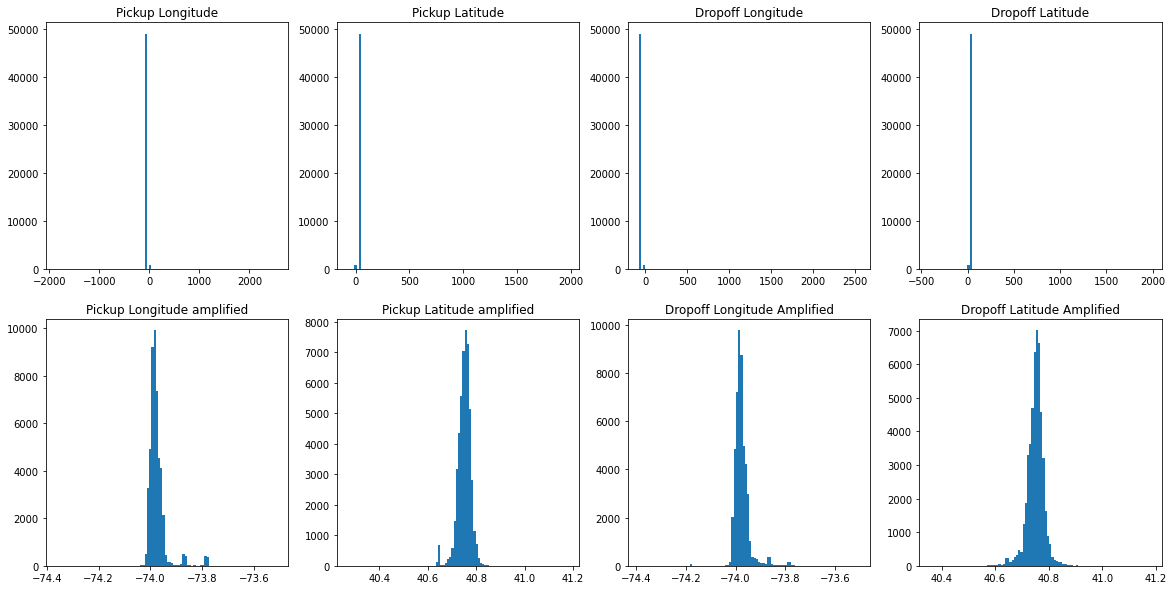

In [ ]:
amp = 0.5
fig,ax = plt.subplots(2,4,figsize=(20,10))
ax[0,0].hist(p_lon,bins=100)
ax[0,0].set_title('Pickup Longitude')
ax[1,0].hist(p_lon[(p_lon<p_lon.median()+amp) & (p_lon>p_lon.median()-amp)], bins=100);
ax[1,0].set_title('Pickup Longitude amplified')

ax[0,1].hist(p_lat,bins=100)
ax[0,1].set_title('Pickup Latitude')
ax[1,1].hist(p_lat[(p_lat<p_lat.median()+amp) & (p_lat>p_lat.median()-amp)], bins=100);
ax[1,1].set_title('Pickup Latitude amplified')

ax[0,2].hist(d_off_lon,bins=100)
ax[0,2].set_title('Dropoff Longitude')
ax[1,2].hist(d_off_lon[(d_off_lon<d_off_lon.median()+amp) & (d_off_lon>d_off_lon.median()-amp)], bins=100);
ax[1,2].set_title('Dropoff Longitude Amplified')

ax[0,3].hist(d_off_lat,bins=100)
ax[0,3].set_title('Dropoff Latitude')
ax[1,3].hist(d_off_lat[(d_off_lat<d_off_lat.median()+amp) & (d_off_lat>d_off_lat.median()-amp)], bins=100);
ax[1,3].set_title('Dropoff Latitude Amplified')


Observando os gráficos pode se notar que a maior parte dos dados estão concentrados em pequenos ranges. Como a maior parte dos valores estão dentro desse intervalo, será criado um filtro para manter os dados apenas dentro desse intervalo e verificar a quantidade de dado será descartada com o uso desses filtros.

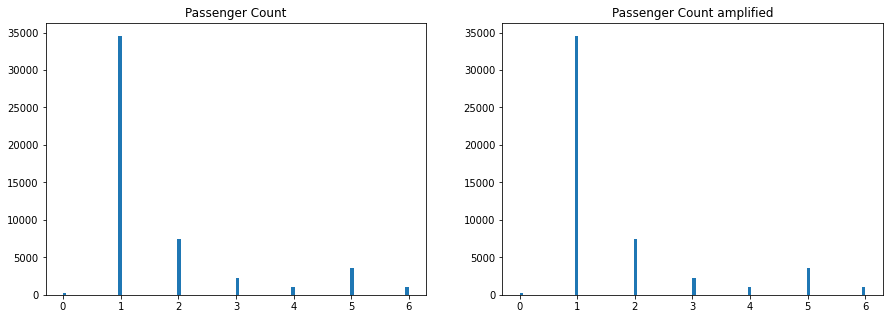

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].hist(pass_c,bins=100)
ax[0].set_title('Passenger Count');
ax[1].hist(pass_c[(pass_c<7) & (pass_c>=0)], bins=100);
ax[1].set_title('Passenger Count amplified');

No caso dos passageiros, serão considerados apenas os valores em que possua pelo menos um passageiro.

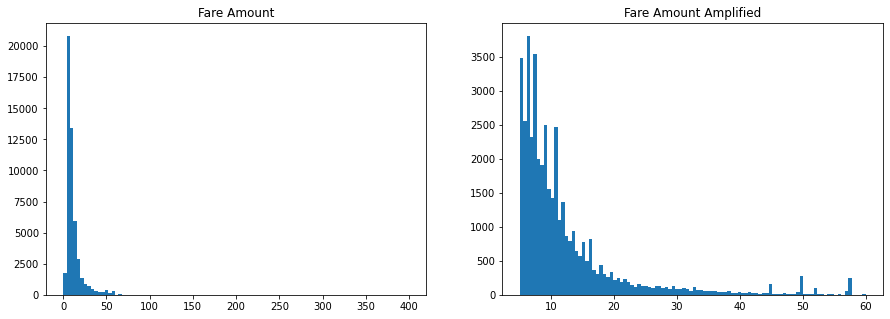

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].hist(f_amount,bins=100)
ax[0].set_title('Fare Amount');
ax[1].hist(f_amount[(f_amount>=5) & (f_amount<=60)], bins=100);
ax[1].set_title('Fare Amount Amplified');

A fim de evitar outliers, serão considerados valores até 60 dolares.

###Criação de filtros para limpeza dos dados

In [ ]:
p_lon_filter = ((p_lon<p_lon.median()+amp) & (p_lon>p_lon.median()-amp))
print(p_lon_filter.value_counts(), '\n', p_lon_filter.value_counts(normalize=True),'\n')

p_lat_filter = ((p_lat<p_lat.median()+amp) & (p_lat>p_lat.median()-amp))
print(p_lat_filter.value_counts(), '\n', p_lat_filter.value_counts(normalize=True),'\n')

doff_lon_filter = ((d_off_lon<d_off_lon.median()+amp) & (d_off_lon>d_off_lon.median()-amp))
print(doff_lon_filter.value_counts(), '\n', doff_lon_filter.value_counts(normalize=True),'\n')

doff_lat_filter = ((d_off_lat<d_off_lat.median()+amp) & (d_off_lat>d_off_lat.median()-amp))
print(doff_lat_filter.value_counts(), '\n', doff_lat_filter.value_counts(normalize=True),'\n')

pass_filter = ((pass_c<7) & (pass_c>0))
print(pass_filter.value_counts(), '\n', pass_filter.value_counts(normalize=True),'\n')

fare_filter = ((f_amount>=2.50) & (f_amount<=60))
print(fare_filter.value_counts(), '\n', fare_filter.value_counts(normalize=True))

True     48980
False     1020
Name: pickup_longitude, dtype: int64 
 True     0.9796
False    0.0204
Name: pickup_longitude, dtype: float64 

True     48992
False     1008
Name: pickup_latitude, dtype: int64 
 True     0.97984
False    0.02016
Name: pickup_latitude, dtype: float64 

True     48999
False     1001
Name: dropoff_longitude, dtype: int64 
 True     0.97998
False    0.02002
Name: dropoff_longitude, dtype: float64 

True     48994
False     1006
Name: dropoff_latitude, dtype: int64 
 True     0.97988
False    0.02012
Name: dropoff_latitude, dtype: float64 

True     49815
False      185
Name: passenger_count, dtype: int64 
 True     0.9963
False    0.0037
Name: passenger_count, dtype: float64 

True     49862
False      138
Name: fare_amount, dtype: int64 
 True     0.99724
False    0.00276
Name: fare_amount, dtype: float64


Como os valores dos filtros utilizados para verificar as coordenadas retiram apenas uma pequena quantidade dos dados, os valores fora dos intervalos dos filtros serão descartados.

In [ ]:
total_filter = p_lon_filter & p_lat_filter & doff_lon_filter & doff_lat_filter & pass_filter & fare_filter
print(total_filter.value_counts(), '\n', total_filter.value_counts(normalize=True))

True     48607
False     1393
dtype: int64 
 True     0.97214
False    0.02786
dtype: float64


In [ ]:
dataset = dataset.drop(total_filter[total_filter==False].index)

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48607 entries, 0 to 49999
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   fare_amount        48607 non-null  float32       
 1   pickup_datetime    48607 non-null  datetime64[ns]
 2   pickup_longitude   48607 non-null  float32       
 3   pickup_latitude    48607 non-null  float32       
 4   dropoff_longitude  48607 non-null  float32       
 5   dropoff_latitude   48607 non-null  float32       
 6   passenger_count    48607 non-null  int32         
dtypes: datetime64[ns](1), float32(5), int32(1)
memory usage: 1.9 MB


##Feature Engineering

Criação de novos dados a partir dos dados contidos no dataset atual

In [ ]:
dataset['hour_of_day'] = dataset['pickup_datetime'].map(lambda date:date.timetuple().tm_hour)
dataset['day_of_week'] = dataset['pickup_datetime'].map(lambda date:date.timetuple().tm_wday)
dataset['day_of_year'] = dataset['pickup_datetime'].map(lambda date:date.timetuple().tm_yday)
dataset['year'] = dataset['pickup_datetime'].map(lambda date:date.timetuple().tm_year)

In [ ]:
dataset.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour_of_day,day_of_week,day_of_year,year
0,7.3,2011-06-21 16:15:00,-73.991875,40.754436,-73.977226,40.774323,3,16,1,172,2011
1,5.7,2012-04-14 14:45:00,-73.984322,40.768509,-73.988472,40.755569,1,14,5,105,2012
2,13.3,2011-10-26 16:56:14,-74.001305,40.724426,-73.971802,40.761963,1,16,2,299,2011
3,16.5,2012-03-08 22:58:00,-74.008240,40.720638,-73.951424,40.730354,2,22,3,68,2012
4,21.0,2012-09-06 21:56:13,-74.005928,40.709415,-73.996780,40.736568,2,21,3,250,2012


Foi desmembrado da coluna de dados pickup_datetime para separar em horas do dia, dias da semana, dias do ano e ano. Foi realizada essa separação para analisar se os dias da semana, horarios do dia e dias do ano influenciam no preço dos valores. 

Como os dias do ano podem ter relevância no cálculo, é necessário analisar se existe ano bissexto dentro da base de dados e caso tenha, quantas corridas foram realizadas no dia 29 de fevereiro.

In [ ]:
len(dataset['pickup_datetime'][dataset['pickup_datetime'].dt.strftime('%m-%d')=='02-29'])

22

Como a quantidade de corridas é um valor baixo, as corridas realizadas nesse dia serão desconsideradas.

In [ ]:
dataset.drop(dataset['pickup_datetime'][dataset['pickup_datetime'].dt.strftime('%m-%d')=='02-29'].index,inplace=True)

Como no ano de 2012 foi ano bissexto, será necessário corrigir o valor da coluna day of year naquele ano. pois o dia 1 de março que era o dia 61, passará a ser o dia 60.

In [ ]:
dataset['day_of_year'][(dataset['year']==2012) & (dataset['day_of_year']>59)] = dataset['day_of_year'] - 1 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Text(0.5, 1.0, 'Years')

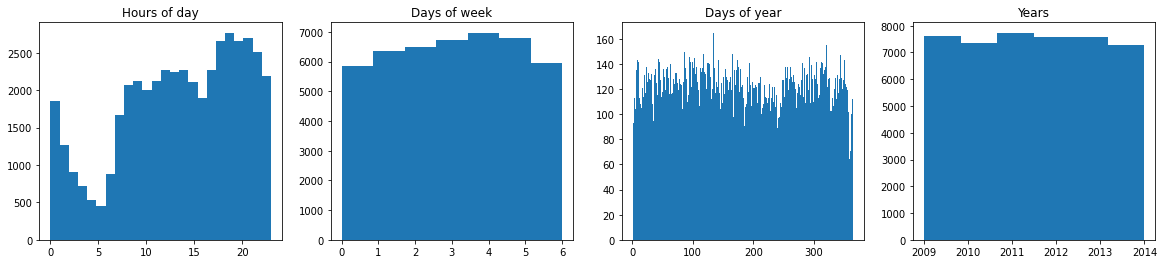

In [ ]:
fig, ax = plt.subplots(1,4,figsize=(20,4))
data_without_2015 = dataset[dataset['year']< 2015]
ax[0].hist(data_without_2015['hour_of_day'], bins=24)
ax[0].set_title('Hours of day')
ax[1].hist(data_without_2015['day_of_week'], bins=7)
ax[1].set_title('Days of week')
ax[2].hist(data_without_2015['day_of_year'], bins =365)
ax[2].set_title('Days of year')
ax[3].hist(data_without_2015['year'], bins=6)
ax[3].set_title('Years')

O ano de 2015 foi retirado para gerar esses graficos pois a base de dados so possui valores até 30 de junho de 2015.

Observando os gráficos pode-se notar que o maior fluxo de corridas ocorre entre as 19 e 22 horas, enquanto o horario da madrugada se encontram os menores fluxos.

Nos dias da semana ocorre uma gradativa, sendo domingo a menor quantidade de corridas e vai aumentando até a sexta-feira.

Em relação aos dias do ano, ocorre uma variação muito grande entre as quantidades de corridas, mas é possível observar que nas festas de fim de ano há uma queda no volume.

Em relação aos anos, não ocorreu uma variação significante em relação aos anos.

###Cálculo das distâncias
Serão utilizados os valores das latitudes e longitudes para calcular através da distância Euclidiana e Manhattan.

####Distância Euclidiana

In [ ]:
#Transformação das latitudes e longitudes de graus para radianos
lon1, lon2 = np.radians(dataset['pickup_longitude']), np.radians(dataset['dropoff_longitude'])
lat1, lat2 = np.radians(dataset['pickup_latitude']), np.radians(dataset['dropoff_latitude'])

#subtração das latitudes e longitudes 
dlon = lon2-lon1
dlat = lat2-lat1

#Distância Euclideana utilizando a formula de Haversine - (km)
a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
dataset['euclidean_distance'] = 6373 * c

####Distância Manhattan

In [ ]:
#Distância Manhattan - (km)
a1 = np.sin(dlon/2)**2
c1 = 2 * np.arctan2(np.sqrt(a1), np.sqrt(1-a1))
a2 = np.sin(dlat/2)**2
c2 = 2 * np.arctan2(np.sqrt(a2), np.sqrt(1-a2))
dataset['manh_distance'] = 6373 * (c1+c2)

In [ ]:
dataset.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour_of_day,day_of_week,day_of_year,year,euclidean_distance,manh_distance
0,7.3,2011-06-21 16:15:00,-73.991875,40.754436,-73.977226,40.774323,3,16,1,172,2011,2.532987,3.841528
1,5.7,2012-04-14 14:45:00,-73.984322,40.768509,-73.988472,40.755569,1,14,5,104,2012,1.481068,1.900442
2,13.3,2011-10-26 16:56:14,-74.001305,40.724426,-73.971802,40.761963,1,16,2,299,2011,4.859137,7.456281
3,16.5,2012-03-08 22:58:00,-74.008240,40.720638,-73.951424,40.730354,2,22,3,67,2012,4.910071,7.400820
4,21.0,2012-09-06 21:56:13,-74.005928,40.709415,-73.996780,40.736568,2,21,3,249,2012,3.116748,4.037156


Como os dados da coluna pickup_datetime foi separado em outros rótulos, os atributos dela sera apagado da base de dados.

In [ ]:
dataset.drop('pickup_datetime',axis=1,inplace=True)
dataset.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour_of_day,day_of_week,day_of_year,year,euclidean_distance,manh_distance
0,7.3,-73.991875,40.754436,-73.977226,40.774323,3,16,1,172,2011,2.532987,3.841528
1,5.7,-73.984322,40.768509,-73.988472,40.755569,1,14,5,104,2012,1.481068,1.900442
2,13.3,-74.001305,40.724426,-73.971802,40.761963,1,16,2,299,2011,4.859137,7.456281
3,16.5,-74.008240,40.720638,-73.951424,40.730354,2,22,3,67,2012,4.910071,7.400820
4,21.0,-74.005928,40.709415,-73.996780,40.736568,2,21,3,249,2012,3.116748,4.037156


##Pré-processamento

A partir dos tratamentos realizados anteriormente, agora será realizada a divisão e normalização dos dados.

In [ ]:
x_train = dataset.drop('fare_amount',axis=1)
y_train = dataset['fare_amount']

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_train_scaled

array([[0.42172366, 0.53244966, 0.46228002, ..., 0.33333333, 0.04529875,
        0.05185808],
       [0.43080423, 0.54788474, 0.44873409, ..., 0.5       , 0.02648671,
        0.0256547 ],
       [0.4103867 , 0.49953347, 0.46881404, ..., 0.33333333, 0.08689852,
        0.10065484],
       ...,
       [0.42812592, 0.51009828, 0.4304186 , ..., 0.16666667, 0.02585745,
        0.02676745],
       [0.4061491 , 0.51863381, 0.45108671, ..., 0.16666667, 0.03871523,
        0.04798655],
       [0.44256311, 0.5410061 , 0.44934062, ..., 0.66666667, 0.03298116,
        0.03982299]])

# Treinamento dos algoritmos de regressão

In [ ]:
from sklearn.model_selection import cross_val_score
cv = 5 
scoring = 'neg_mean_squared_error'

#Definição da quantidade máxima de processadores para treinar o modelo
import multiprocessing
n_jobs = multiprocessing.cpu_count() - 1

###Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
linear = LinearRegression()
score_linear = cross_val_score(linear,x_train_scaled,y_train,
                               scoring=scoring,cv=cv,n_jobs=n_jobs)
mse_linear=np.sqrt(-score_linear.mean())
mse_linear

3.9360282468213863

###Ridge Regression

In [ ]:
from sklearn.linear_model import Ridge

ridge = Ridge()
score_ridge = cross_val_score(ridge,x_train_scaled,y_train,
                              scoring=scoring,cv=cv,n_jobs=n_jobs)
mse_ridge = np.sqrt(-score_ridge.mean())
mse_ridge

3.9414138593262247

###Lasso Regression

In [ ]:
from sklearn.linear_model import Lasso

lasso = Lasso()
score_lasso = cross_val_score(lasso,x_train_scaled,y_train,
                              scoring=scoring,cv=cv,n_jobs=n_jobs)
mse_lasso = np.sqrt(-score_lasso.mean())
mse_lasso

8.835696335152509

### KNN

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor()
score_knn = cross_val_score(knn,x_train_scaled,y_train,
                            scoring=scoring,cv=cv,n_jobs=n_jobs)

mse_knn = np.sqrt(-score_knn.mean())
mse_knn

4.940455534777464

### Decision Tree Regressor

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor()
score_tree = cross_val_score(tree,x_train_scaled,y_train,
                             scoring=scoring,cv=cv,n_jobs=n_jobs)
mse_tree = np.sqrt(-score_tree.mean())
mse_tree

4.727205768202781

### Random Forest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
score_rf = cross_val_score(rf,x_train_scaled,y_train,
                           scoring=scoring,cv=cv,n_jobs=n_jobs)
mse_rf = np.sqrt(-score_rf.mean())
mse_rf

3.328324510948396

###Gradient Boosting Regressor

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

gb = GradientBoostingRegressor()
score_gb = cross_val_score(gb,x_train_scaled,y_train,
                           scoring=scoring,cv=cv,n_jobs=n_jobs)
mse_gb = np.sqrt(-score_gb.mean())
mse_gb

3.348316085953309

## Redes Neurais

In [ ]:
from sklearn.neural_network import MLPRegressor

nn = MLPRegressor()
score_nn = cross_val_score(nn,x_train_scaled,y_train,
                           scoring=scoring,cv=cv,n_jobs=n_jobs)
mse_nn = np.sqrt(-score_nn.mean())
mse_nn

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:699: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:699: UserWarning: Training i

3.7524045469435277

Observando os modelos analisados, foi escolhido o modelo Gradient Boosting Regressor porque gerou um bom resultado e um menor custo computacional do que outros modelos.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

x_train1,x_test1,y_train1,y_test1 = train_test_split(x_train_scaled,y_train,test_size=0.2,random_state=0)

parameters = {'loss':('squared_error', 'absolute_error', 'huber', 'quantile'),
              'learning_rate':[0.01,0.05,0.1,0.5],
              'n_estimators':[50,100,150,200]}

gb = GradientBoostingRegressor()
grad_boosting = GridSearchCV(gb,param_grid=parameters,
                             cv=cv,n_jobs=n_jobs)

grad_boosting.fit(x_train1,y_train1)

print(grad_boosting.best_params_)

{'learning_rate': 0.5, 'loss': 'huber', 'n_estimators': 200}


In [ ]:
grad_boosting.best_score_

0.8640393906395826

###Treinando o modelo de Gradient Boosting

Foram utilizados os hiperparametros que apresentaram o melhor resultado após a aplicação do grid search.

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

x_train1,x_test1,y_train1,y_test1 = train_test_split(x_train_scaled,y_train,test_size=0.2,random_state=0)

model_gb = GradientBoostingRegressor(loss='huber',n_estimators=200,learning_rate=0.5)
model_gb.fit(x_train1,y_train1)

GradientBoostingRegressor(learning_rate=0.5, loss='huber', n_estimators=200)

In [ ]:
model_gb.score(x_test1,y_test1)

0.8339225674920565

In [ ]:
y_pred = model_gb.predict(x_test1)
y_pred

array([ 9.03525173,  6.89510959, 11.9364619 , ..., 32.45758429,
        6.8711708 ,  9.20690303])

In [ ]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test1,y_pred)
rmse = np.sqrt(mse)
rmse

3.5591639004306717

O resultado na base de dados de texte encontrou um valor de rmse igual a 3.559...

###Feature importances

Após a aplicação do modelo, realizou uma análise para verificar quais os atributos mais importantes para desenvolver o modelo.

In [ ]:
feature_importances = model_gb.feature_importances_
feature_importances

array([1.45657182e-02, 5.74907409e-03, 1.91167029e-02, 1.63519135e-02,
       3.06238662e-04, 1.26456150e-02, 3.20631001e-03, 3.34658491e-03,
       3.47863978e-02, 8.75635933e-01, 1.42895118e-02])

In [ ]:
argsort = np.argsort(feature_importances)
argsort

array([ 4,  6,  7,  1,  5, 10,  0,  3,  2,  8,  9])

In [ ]:
fi_sorted = feature_importances[argsort]
fi_sorted

array([3.06238662e-04, 3.20631001e-03, 3.34658491e-03, 5.74907409e-03,
       1.26456150e-02, 1.42895118e-02, 1.45657182e-02, 1.63519135e-02,
       1.91167029e-02, 3.47863978e-02, 8.75635933e-01])

In [ ]:
feature_names_sorted = x_train.columns[argsort]
feature_names_sorted

Index(['passenger_count', 'day_of_week', 'day_of_year', 'pickup_latitude',
       'hour_of_day', 'manh_distance', 'pickup_longitude', 'dropoff_latitude',
       'dropoff_longitude', 'year', 'euclidean_distance'],
      dtype='object')

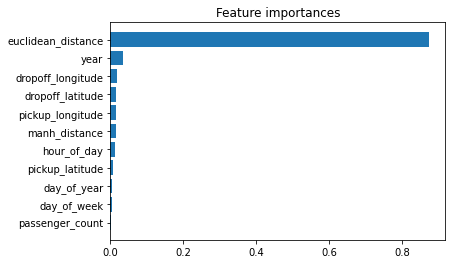

In [ ]:
plt.barh(feature_names_sorted,fi_sorted)
plt.title('Feature importances')
plt.show();

Observando o gráfico acima, pode se notar que o atribute que mais se destacou em relação aos demais foi o cálculo da distância euclidiana. Lembrando que esse dado foi gerado a partir dos valores das coordenadas, ou seja, foi uma variável criada a partir da base de dados original.

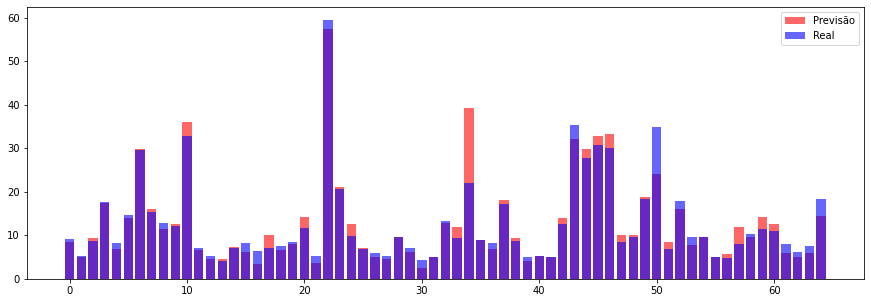

In [ ]:
plt.figure(figsize=(15,5))
plt.bar(list(range(len(y_test1[::150]))), y_test1.values[::150], alpha = 0.6, color='red',label='Previsão')
plt.bar(list(range(len(y_test1[::150]))), y_pred[::150], alpha = 0.6, color='blue',label='Real')
plt.legend()
plt.show()

O gráfico mostra os valores reais na base de dados de teste(azul) e a previsão(vermelho). Observa-se que em grande parte dos resultados os valores são próximos, porém alguns valores tem uma grande discrepância.

O valor RMSE deveria ser abaixo de 5. Com o modelo do Gradient Boosting foi encontrado um valor de 3,43, ou seja, o objetivo foi atingido. 

Durante a fase de escolha de modelos, foi encontrado valores melhores utilizando outros modelos, porém o custo computacional foi extremamente elevado. 

Possiveis melhorias podem ser feitas para diminuir ainda mais o valor da raiz quadrada do erro médio, como: 

- Utilizar toda a base de dados.
- Aplicar os modelos com maiores custos computacionais, como as redes neurais.
- análisar os valores que deram uma discrepância muito grande do previsto para o real.

###Salvando o modelo treinado

In [ ]:
import pickle
pickle.dump(model_gb, open('gradient_boosting_finalizado.sav', 'wb'))

##Preparação do resultado a ser enviado

In [ ]:
data_test = pd.read_csv('/content/test (1).csv',
                        parse_dates=['pickup_datetime'],
                        dtype = {'fare_amount': np.float32,'pickup_latitude':np.float32,
                                 'pickup_longitude':np.float32,'dropoff_latitude':np.float32,
                                 'dropoff_longitude':np.float32,'passenger_count':np.int32,
                                 'key':str})

In [ ]:
data_test.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24+00:00,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24+00:00,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44+00:00,-73.982521,40.751259,-73.979652,40.746140,1
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12+00:00,-73.981163,40.767807,-73.990448,40.751637,1
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12+00:00,-73.966049,40.789776,-73.988564,40.744427,1


In [ ]:
key = data_test['key']
pdt = data_test['pickup_datetime']
pdt = pdt.map(lambda date: date.tz_localize(None))
data_test.drop(['key'], axis = 1, inplace=True)
data_test['pickup_datetime'] = pdt

# Novos atributos
data_test['hour_of_day'] = data_test['pickup_datetime'].map(lambda date: date.timetuple().tm_hour)
data_test['day_of_week'] = data_test['pickup_datetime'].map(lambda date: date.timetuple().tm_wday)
data_test['day_of_year'] = data_test['pickup_datetime'].map(lambda date: date.timetuple().tm_yday)
data_test['year'] = data_test['pickup_datetime'].map(lambda date: date.timetuple().tm_year)
data_test.drop('pickup_datetime', axis = 1, inplace = True)

# Distância
lon1, lon2 = np.radians(data_test['pickup_longitude']), np.radians(data_test['dropoff_longitude'])
lat1, lat2 = np.radians(data_test['pickup_latitude']), np.radians(data_test['dropoff_latitude'])
dlon = lon2 - lon1
dlat = lat2 - lat1

a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
data_test['euclidean_distance'] = 6373 * c

a1 = np.sin(dlon/2)**2
c1 = 2 * np.arctan2(np.sqrt(a1), np.sqrt(1-a1))
a2 = np.sin(dlat/2)**2
c2 = 2 * np.arctan2(np.sqrt(a2), np.sqrt(1-a2))
data_test['manh_distance'] = 6373 * (c1+c2)

In [ ]:
data_test.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour_of_day,day_of_week,day_of_year,year,euclidean_distance,manh_distance
0,-73.973320,40.763805,-73.981430,40.743835,1,13,1,27,2015,2.324087,3.123212
1,-73.986862,40.719383,-73.998886,40.739201,1,13,1,27,2015,2.426061,3.541439
2,-73.982521,40.751259,-73.979652,40.746140,1,11,5,281,2011,0.618597,0.888493
3,-73.981163,40.767807,-73.990448,40.751637,1,21,5,336,2012,1.961528,2.831859
4,-73.966049,40.789776,-73.988564,40.744427,1,21,5,336,2012,5.388903,7.548207


In [ ]:
X_test = data_test
X_test_scaled = scaler.transform(X_test)

y_pred_test = model_gb.predict(X_test_scaled)
y_pred_test

array([10.54823594, 10.4358036 ,  4.45894125, ..., 46.92684045,
       19.16093693,  6.62911738])

In [ ]:
submission = pd.DataFrame({'key':key,'fare_amount':y_pred_test})

In [ ]:
submission.head()
print(submission.shape)

(9914, 2)


In [ ]:
submission.to_csv('submission.csv', index = False)